# Building Forecasting Pipelines

In previous tutorials, we learned how to forecast a univariate time series, apply transformations, and include exogenous variables. In this tutorial, we bring these ideas together and show how to combine transformations and models in **pipelines**.

Pipelines help you structure forecasting workflows so that every transformation is applied safely (no leakage), reproducibly, and in the correct order. They also make it easy to swap models, add or remove preprocessing, and later perform tuning or backtesting with confidence.

**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand when and why to use a forecasting pipeline
- Use `TransformedTargetForecaster` for target (y) transformations
- Use `ForecastingPipeline` for exogenous (X) transformations
- Combine target and exogenous transformations in a single workflow
- Chain estimators with operator shortcuts (`*` and `**`)
- Inspect and modify pipeline parameters programmatically


## 1. Why pipelines?

When we manually applied transformations earlier, it was easy to accidentally fit them on the full dataset. That would cause **data leakage**, since information from the future could influence the training phase. Pipelines prevent this by remembering two things:

* The exact ordered list of transformations applied
* That each transformation must be fit only on training data, and inverted (if needed) after forecasting

Other benefits:
- Reproducibility: one object captures your full workflow
- Swappability: change model or transformation without rewriting code
- Safety: inverse transforms of the target happen automatically
- Tuning readiness: all hyperparameters become accessible through a single interface (`get_params` / `set_params`)

We now walk through three levels: (1) target-only pipelines, (2) pipelines for exogenous features, and (3) combined pipelines.


In [4]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd

from sktime.datasets import Airline
from sktime.utils.plotting import plot_series

# Load a single dataset (same one used in earlier tutorials)
y = Airline().load("y")  # monthly passenger counts

# Simple temporal split (last 12 periods as forecast horizon)
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

# (Optional) create a very simple exogenous feature frame from the timestamp index
# We keep it minimal: month number and whether month is peak-season (e.g., July/August)
X = pd.DataFrame(index=y.index)
X["month"] = X.index.month
X["is_peak"] = X["month"].isin([7, 8]).astype(int)

X_train, X_test = X.loc[y_train.index], X.loc[y_test.index]

# Inspect first rows
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

## 2. Target (y) transformation pipelines

We start with transformations that act directly on the target series. In the transformations tutorial, we manually applied log, differencing, detrending, etc. Here we package them so they are always applied (and inverted) correctly around the forecaster.

The tool for this is `TransformedTargetForecaster`.

In [28]:
from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.difference import Differencer

# Chain: log transform -> first difference -> seasonal exponential smoothing
forecaster_y = TransformedTargetForecaster(
    steps=[
        ("log", LogTransformer()),
        ("diff", Differencer(lags=1)),
        ("model", AutoREG(lags=[1, 2, 3, 4])),
    ]
)

forecaster_y

TransformedTargetForecaster(steps=[('log', LogTransformer()),
                                   ('diff', Differencer()),
                                   ('model', AutoREG(lags=[1, 2, 3, 4]))])

### 2.1 Fit & forecast

We fit on the training portion; during prediction, inverse transforms are applied automatically so outputs are on the original scale.

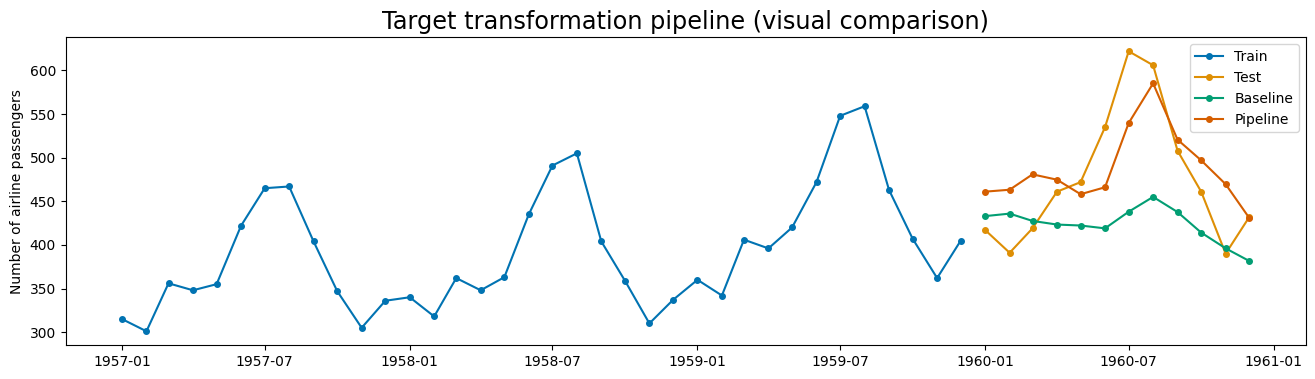

In [31]:
# Fit the target transformation pipeline
forecaster_y.fit(y_train, X=X_train)

# Forecast next 12 months (relative horizon 1..12)
y_pred_pipe = forecaster_y.predict(fh=range(1, 13), X=X_test)

# Baseline: same model without transformations (for visual comparison only)
baseline = AutoREG(lags=[1, 2, 3, 4])
baseline.fit(y_train, X=X_train)
y_pred_base = baseline.predict(fh=range(1, 13), X=X_test)

# Plot – visual inspection only (metrics & backtesting covered in another tutorial)
plot_series(
    y_train.iloc[-36:],
    y_test,
    y_pred_base,
    y_pred_pipe,
    labels=["Train", "Test", "Baseline", "Pipeline"],
    title="Target transformation pipeline (visual comparison)",
)
plt.show()

## 3. Pipelines for exogenous (X) transformations

Even with a univariate target we can engineer calendar-based features (here: month number and a simple peak-season flag). These play the role of exogenous variables. We may want to scale, filter or otherwise process them before the model sees them.

`ForecastingPipeline` applies steps to `X` (not `y`).

In [32]:

from sktime.forecasting.auto_reg import AutoREG
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.fourier import FourierFeatures

pipe_X = ForecastingPipeline(
    steps=[
        (
            "fourier_terms",
            FourierFeatures(
                sp_list=[12], fourier_terms_list=[3], keep_original_columns=True
            ),
        ),
        ("forecaster", AutoREG(lags=[1, 2, 3, 4])),
    ]
)
pipe_X

ForecastingPipeline(steps=[('fourier_terms',
                            FourierFeatures(fourier_terms_list=[3],
                                            keep_original_columns=True,
                                            sp_list=[12])),
                           ('forecaster', AutoREG(lags=[1, 2, 3, 4]))])

### 3.1 Fit & forecast with X pipeline

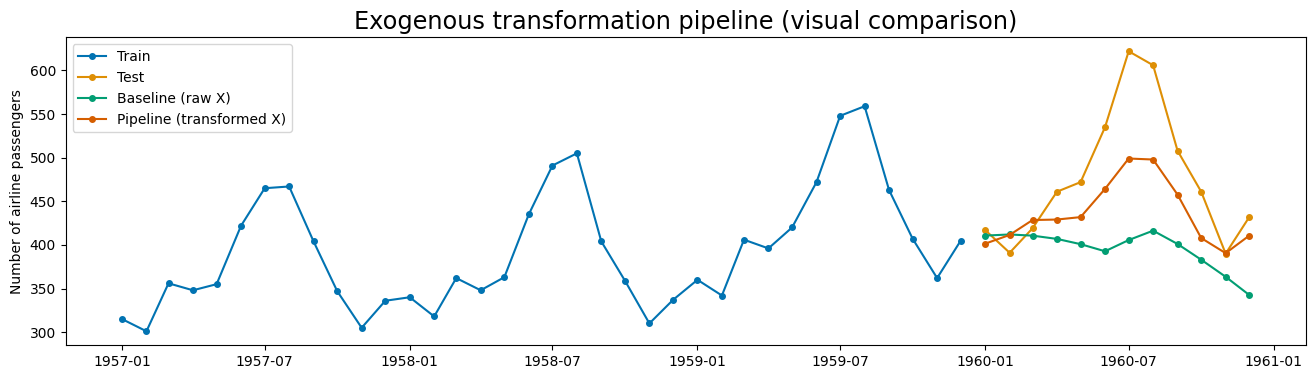

In [33]:
# Forecast horizon uses test index
y_fh = y_test.index

# Fit pipeline with exogenous variables engineered from date index
pipe_X.fit(y_train, X=X_train)
y_pred_X = pipe_X.predict(fh=y_fh, X=X_test)

# Baseline without X transformations (still uses raw X)
baseline_X = AutoREG(lags=[1, 2])
baseline_X.fit(y_train, X=X_train)
y_pred_X_base = baseline_X.predict(fh=y_fh, X=X_test)

plot_series(
    y_train.iloc[-36:],
    y_test,
    y_pred_X_base,
    y_pred_X,
    labels=["Train", "Test", "Baseline (raw X)", "Pipeline (transformed X)"],
    title="Exogenous transformation pipeline (visual comparison)",
)
plt.show()

## 4. Combining target and exogenous transformations

We now merge both ideas: stabilize/transform the target and engineer/transform exogenous features, all in one object. Nesting ensures correct order: fit/invert target transforms around forecasting; transform `X` before it reaches the forecaster.

In [34]:

# X side: scale -> create lags -> impute any introduced NaN -> optional feature selection
pipe_X_full = ForecastingPipeline(
    steps=[
        (
            "fourier_terms",
            FourierFeatures(
                sp_list=[12], fourier_terms_list=[3], keep_original_columns=True
            ),
        ),
        ("forecaster", AutoREG(lags=[1, 2, 3, 4])),
    ]
)

# Wrap with y transformations (log + difference) to stabilize variance and remove level
full_pipeline = TransformedTargetForecaster(
    steps=[
        ("log", LogTransformer()),
        ("diff", Differencer(lags=1)),
        ("model", pipe_X_full),
    ]
)
full_pipeline

TransformedTargetForecaster(steps=[('log', LogTransformer()),
                                   ('diff', Differencer()),
                                   ('model',
                                    ForecastingPipeline(steps=[('fourier_terms',
                                                                FourierFeatures(fourier_terms_list=[3],
                                                                                keep_original_columns=True,
                                                                                sp_list=[12])),
                                                               ('forecaster',
                                                                AutoREG(lags=[1,
                                                                              2,
                                                                              3,
                                                                              4]))]))])

An equivalent way to construct this pipeline is to use the `*` and `**` operators to chain the two pipelines we created above:

```python
full_pipeline = (
    LogTransformer()
    * Differencer(lags=1)
    * (
        FourierFeatures(sp_list=[12], fourier_terms_list=[3], keep_original_columns=True)
        ** AutoREG(lags=[1, 2, 3, 4])
    )
    
)
```

### 4.1 Fit & visually inspect combined pipeline

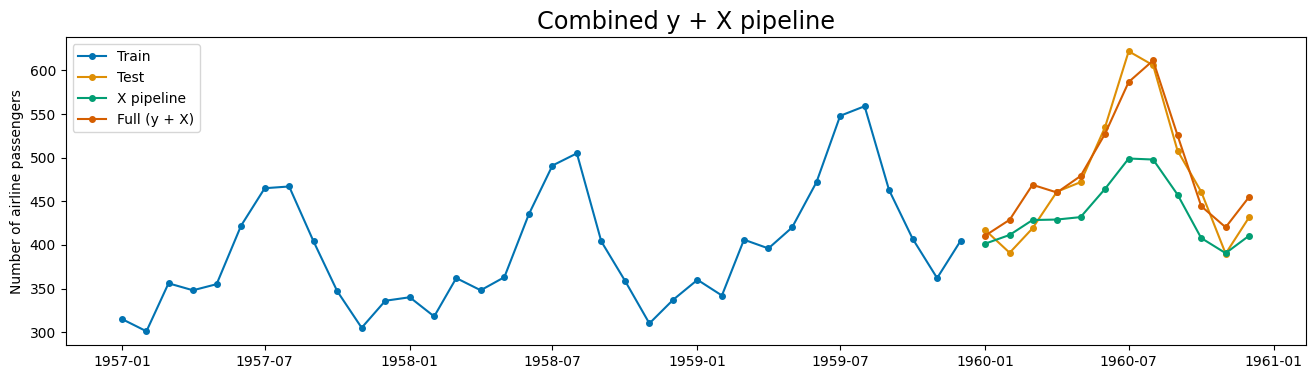

In [44]:
full_pipeline.fit(y_train, X=X_train)
y_pred_full = full_pipeline.predict(fh=y_test.index, X=X_test)

plot_series(
    y_train.iloc[-36:],
    y_test,
    y_pred_X,
    y_pred_full,
    labels=["Train", "Test", "X pipeline", "Full (y + X)"],
    title="Combined y + X pipeline",
)
plt.show()

# 5. Modifying and inspecting parameters

The `get_params` and `set_params` methods work as expected, with hierarchical names for nested steps. This makes it easy to programmatically inspect or modify any part of the pipeline.

Pattern:
`steps__<outer_step>__steps__<inner_step>__<parameter>`


In [49]:
# Example: adjust forecaster lags through the hierarchical parameter name
full_pipeline.get_params()["model__forecaster__lags"]

[1, 2, 3, 4]

In [50]:
full_pipeline.set_params(model__forecaster__lags=[1, 2])
full_pipeline.get_params()["model__forecaster__lags"]

[1, 2]

## Summary

In this tutorial you:
- Used a single dataset to keep focus on pipeline structure
- Built target transformation pipelines with `TransformedTargetForecaster`
- Engineered simple calendar features and processed them with `ForecastingPipeline`
- Combined target and exogenous transformations in a nested pipeline
- Used operator shortcuts for concise pipeline creation
- Previewed parameter inspection and modification (for later tuning)

### Key takeaways
* Pipelines encapsulate repeatable preprocessing + modeling without leakage.
* Target (`y`) vs exogenous (`X`) transformations have distinct pipeline tools.
* Nesting lets you layer transformations cleanly (outer wraps target, inner handles features).
* Parameter names form a predictable path—critical for systematic tuning later.
* Visual inspection is fine at this stage; metrics/backtesting come next.

### Next
Proceed to the backtesting & evaluation tutorial to quantify performance and compare pipeline variants rigorously.